# Investigating Fandango Movie Ratings

The purpose of this notebook is to practice applying Statistical Fundamentals learned by analyzing Fandango Move Ratings by exploring and creating Data Visualization for the dataset. 

Walt Hickey, from FiveThirtyEight, found that there is a significant discrepancy between the number of stars displayed to users and the actual rating. Fandango replied that the cause was a bug in their system rather than being intentional. They promised to fix the bug as soon as possible. The goal of this notebook is to analyze the recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Understanding the Data

In [1]:
import pandas as pd
import numpy as np
fandango = pd.read_csv('fandango_score_comparison.csv')
movie_ratings = pd.read_csv('movie_ratings_16_17.csv')

We will be using the dataset that Hickey analyzed and will be compared to a public dataset which collected movie rating data for movies released in 2016 and 2017.

* `fandango_score_comparison.csv` —  contains every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango. The data from Fandango was pulled on Aug. 24, 2015.

* `movie_ratings_16_17.csv` — contains movie ratings data for 214 of the most popular movies (with a significant number of votes) released in 2016 and 2017. As of March 22, 2017, the ratings were up to date. Significant changes should be expected mostly for movies released in 2017.


In [2]:
fandango.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [3]:
movie_ratings.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


After exploring both the dataset briefly, we are going to isolate the columns that offer information about Fandango's ratings so we have just the data we are interested in more than readily available for use later.

In [4]:
new_fandango = fandango[['FILM','Fandango_Stars','Fandango_Ratingvalue','Fandango_votes',
                         'Fandango_Difference']]
new_movie_ratings = movie_ratings[['movie','year','fandango']]

Hickey only included movies in the dataset with at least 30 reviews, while the other dataset includes 214 most popular movies in 2016 and 2017. 

## Changing the Goal of our Analysis
The sampling process were not random, thus our resulting samples are very unlikely to be representative of the population. Since it is next to impossible to collect a new sample previous to Hickey's analysis, we have an alternative: change the goal of our analysis by placing some limitations on it.

Our new goal is finding out whether there's any difference between Fandago's ratings for popular movies in 2015 and Fandango's rating for popular movies in 2016.

## Isolating the Samples We Need
After changing our goal, the new population of interest are Fandango's ratings for popular movies in 2015 and 2016. We will be using Hickey's benchmark to determine which movies are considered popular. 
Let's double-check our first sample:

In [5]:
sum(new_fandango['Fandango_votes'] < 30)

0

In our second sample, since the sampling criteria is movie popularity, the sample does not provide information on the number of fan ratings. Thus, we will randomly sample 10 movies and check the amount of fan ratings ourselves on the Fandango's website. 

*Fandango has replaced their 5 star fan ratings with Rotten Tomatoes Audience Score from 2021. Therefore, I will find their rating counts on Rottentomotoes.com* 

In [6]:
new_movie_ratings.sample(10, random_state=5)

,movie,year,fandango
21,Before the Flood,2016,3.5
54,Fifty Shades of Black,2016,2.5
84,Jason Bourne,2016,4.0
102,Manchester by the Sea,2016,3.5
26,Blood Father,2016,4.0
202,Under the Shadow,2016,4.0
208,Why Him?,2016,4.0
28,Busanhaeng,2016,4.5
6,A Street Cat Named Bob,2016,4.5
161,The Autopsy of Jane Doe,2016,4.5


All 10 movies randomly sampled received more than 30 ratings. It is safe to move forward with a bit more confidence

We noticed that in the two datasets, there are movies that were not released in 2015 and 2016. We will isolate only the movies released in 2015 and 2016. First, lets look at the frequency distribution of the `Year` column in the two datasets before isolating the movies

In [7]:
pd.options.mode.chained_assignment = None

new_fandango['Year'] = new_fandango['FILM'].str[-5:-1].copy()
print(new_fandango['Year'].value_counts())
print(new_movie_ratings['year'].value_counts())

2015    129
2014     17
Name: Year, dtype: int64
2016    191
2017     23
Name: year, dtype: int64


Now lets isolate both the dataset

In [8]:
fandango_2015 = new_fandango[new_fandango['Year'] == '2015']
fandango_2016 = new_movie_ratings[new_movie_ratings['year'] == 2016]
print(fandango_2015['Year'].value_counts())
print(fandango_2016['year'].value_counts())

2015    129
Name: Year, dtype: int64
2016    191
Name: year, dtype: int64


## Visualizing the Frequency Distribution for 2015 and 2016
We will be using kernel density plots to compare the shape of the two distribution. Our objective is to figure out whether there is a difference between Fandango's ratings on popular movies in the year 2015 and 2016.

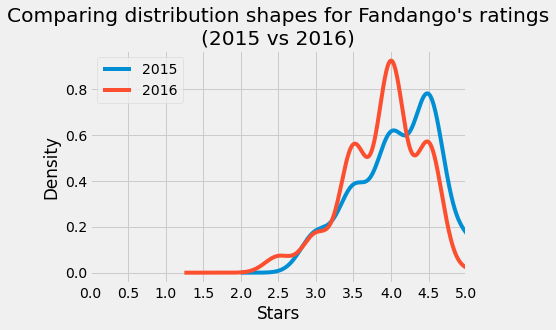

In [9]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label='2015', legend=True)
fandango_2016['fandango'].plot.kde(label='2016', legend=True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)")
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(np.arange(0,5.1,.5))
plt.show()

* We can see that both of the distribution are left skewed, suggesting that popular movies in Fandango are mostly given high ratings.
* The distribution of Fandango's rating in 2016 is slightly shifted to the left comapred to the distribution of Fandango's rating in 2015, suggesting that popular movies in 2016 were rating lower than popular movies in 2015

# Comparing Relative Frequencies
We will now examine and compare the relative frequencies between the two distribution

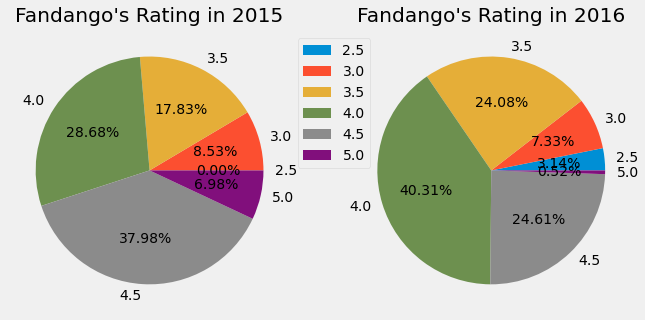

In [10]:
pie_1 = dict(fandango_2015['Fandango_Stars'].value_counts(normalize=True).sort_index() * 100)
pie_2 = dict(fandango_2016['fandango'].value_counts(normalize=True).sort_index() * 100)

df = pd.DataFrame({'Fandango\'s Rating in 2015': [0] + list(pie_1.values()),
                   'Fandango\'s Rating in 2016': list(pie_2.values())},
                  index=['2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])

fit, ax = plt.subplots(1,2, figsize=(10,5))
for ax, col in zip(ax, list(df.columns)):
    ax.pie(df[col],labels=df.index, autopct='%.2f%%')
    ax.set(ylabel='', title=col)
ax.legend(bbox_to_anchor=(0.1, 0.99))
plt.show()

In 2015, very high ratings (4.5 - 5 stars) had significant higher percentages comapred to 2016. There were just under 7% of the movies had perfect rating of 5 stars. Compared to the percentage from 2016, lower than %1 of the movies had perfect rating of 5 stars. 

In 2016, there was a greater percentages of movies that had 3.5 - 4 stars. There was 40% of movies that received 4 stars. Compared to the percentage from 2015, about 29% of movies received 4 stars.

The percentage of perfect ratings decreased in 2016, however other ratings has their percentage increased. We also noticed that the minimum rating in 2016 was lower than 2015.

Now I am going to compare some key summary statistics between two samples to get a more precise picture of the direction of the difference.

In [11]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


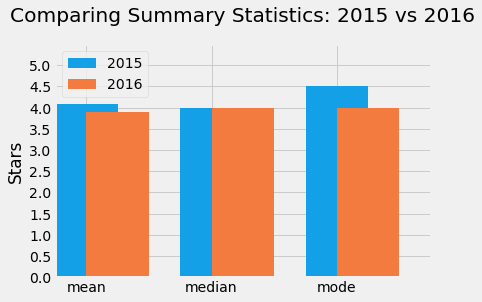

In [12]:
summary['2015'].plot.bar(color='#14a0e6', align='center', label='2015', width=0.5)
summary['2016'].plot.bar(color='#f37b3f', align='edge', label='2016', rot=0, width=0.5)

plt.title('Comparing Summary Statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend()
plt.show()

In [13]:
mean_change = (mean_2016 - mean_2015) / mean_2015
mode_change = (mode_2016 - mode_2015) / mode_2015
print(mean_change)
print(mode_change)

-0.04842683568951993
-0.1111111111111111


* Although both of our samples have the same median, our first sample (2015) has a higher mean than our second sample (2016).
* The mean rating in 2016 dropped by about 5% compared to the mean rating in 2015
* The mode of the ratings in 2016 also dropped by about 11% compared to the mode of the ratings in 2015

## Summary
In the beginning, our goal was to analyze the recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis. However, as I was examining the representativeness of our samples, I determined that the sample population was not a good representation of our interest to our original goal. Thus, I adjusted our goal which is a good proxy for the initial goal: to determine if there is difference between Fandago's ratings for popular movies in 2015 and Fandango's rating for popular movies in 2016.

Our analysis exposed to us that there was a difference between Fandango's rating for popular movies in 2015 and 2016. The movie ratings were lower in 2016 than in 2015 on average. This can be caused by the movies released in 2015 being overall "better" than the movies released in 2016. Alternatively, it could be that Fandango did fix their rating system to accurately depict the real rating. We cannot be completely sure what caused the change. Definitely deserves a deeper analysis.